In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt 

NOTE: Using SIMULATED data (no live API calls).

--- Pairs Trading Analysis: KO vs PEP ---
Data points available: 2500

--- Step 1: OLS Regression ---
R-squared: 0.9966
Estimated Hedge Ratio (β): 0.3490

--- Step 2 & 3: ADF Test ---
ADF Test p-value: 0.000000
Critical Value (5%): -2.8627
The spread is stationary (cointegrated pair).

--- Backtest Summary ---
Total Return: 209.34%
Annualized Sharpe Ratio: 1.45


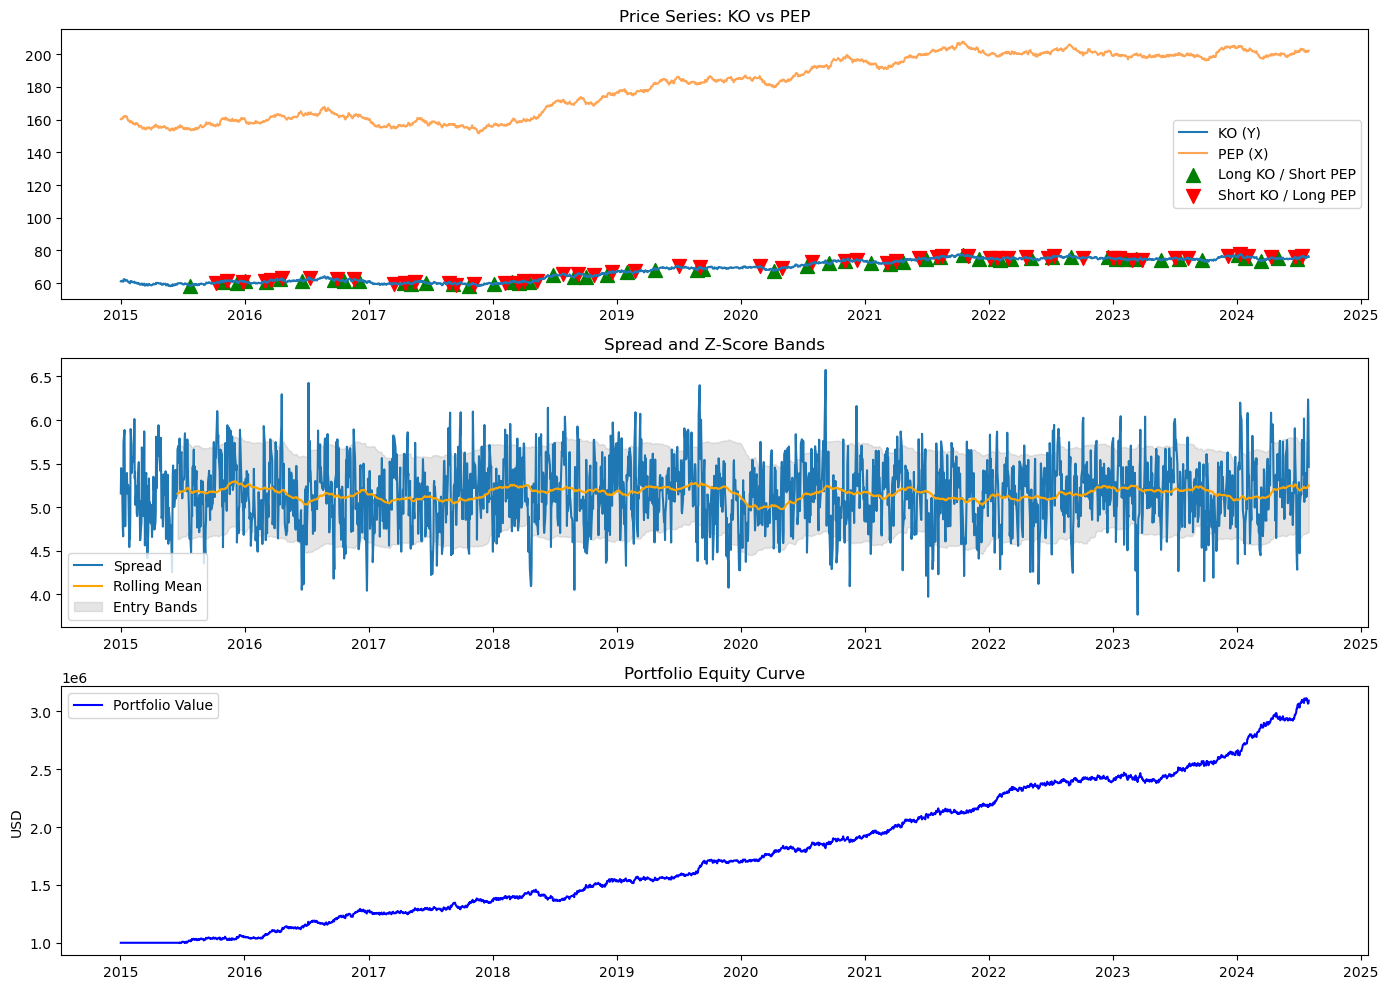

In [49]:
ALPHA_VANTAGE_KEY = "HBI3A8C4Z761R727"
SYMBOL_Y = 'KO'   # Coca-Cola (Asset Y)
SYMBOL_X = 'PEP'  # PepsiCo (Asset X)
INITIAL_CAPITAL = 1000000

def fetch_real_world_data(api_key, symbol_y=SYMBOL_Y, symbol_x=SYMBOL_X):
    """
    Simulate two cointegrated price series.
    """
    T = 2500 # 10 years of trading days, since 1 trading year approximately ~ 250 days 
    np.random.seed(42)

    pep_base = np.cumsum(np.random.normal(0, 0.5, T)) + 160
    prices_X = pd.Series(pep_base, name=symbol_x)

    spread_noise = np.random.normal(0, 0.3, T)
    spread = np.zeros(T)
    for t in range(1, T):
        spread[t] = 0.6 * spread[t - 1] + spread_noise[t]

    beta_true = 0.35
    alpha_true = 5.0
    ko_prices = alpha_true + beta_true * pep_base + spread
    prices_Y = pd.Series(ko_prices, name=symbol_y)

    dates = pd.date_range(start='2015-01-01', periods=T, freq='B')
    prices_X.index = dates
    prices_Y.index = dates

    print("NOTE: Using SIMULATED data (no live API calls).")
    return prices_Y, prices_X


# --- 2. Fetch Data ---
prices_Y, prices_X = fetch_real_world_data(ALPHA_VANTAGE_KEY)
print(f"\n--- Pairs Trading Analysis: {prices_Y.name} vs {prices_X.name} ---")
print(f"Data points available: {len(prices_Y)}\n")


# --- 3. Engle-Granger Cointegration Test ---
X_ols = sm.add_constant(prices_X)
model = sm.OLS(prices_Y, X_ols).fit()
alpha_ols = model.params['const']
beta_ols = model.params[SYMBOL_X]

print("--- Step 1: OLS Regression ---")
print(f"R-squared: {model.rsquared:.4f}")
print(f"Estimated Hedge Ratio (β): {beta_ols:.4f}")

spread_calc = prices_Y - beta_ols * prices_X
adf_result = adfuller(spread_calc)
p_value = adf_result[1]
critical_values = adf_result[4]

print("\n--- Step 2 & 3: ADF Test ---")
print(f"ADF Test p-value: {p_value:.6f}")
print(f"Critical Value (5%): {critical_values['5%']:.4f}")

if p_value >= 0.05:
    print("Spread not stationary — stopping.")
    exit()
else:
    print("The spread is stationary (cointegrated pair).")


# --- 4. Trading Signal Generation ---
lookback = 120
rolling_mean = spread_calc.rolling(window=lookback).mean()
rolling_std = spread_calc.rolling(window=lookback).std()
z_score = (spread_calc - rolling_mean) / rolling_std

entry_threshold = 1.4
exit_threshold = 0.6


signals = pd.Series(0, index=spread_calc.index)
signals[z_score.shift(1) > entry_threshold] = -1
signals[z_score.shift(1) < -entry_threshold] = 1

positions = signals.replace(0, np.nan).ffill().fillna(0)
positions[np.abs(z_score) < exit_threshold] = 0
positions = positions.replace(0, np.nan).ffill().fillna(0)


# --- 5. Backtesting ---
# Portfolio allocation: maintain dollar neutrality
notional = INITIAL_CAPITAL / 2


# Daily returns of each asset
returns_Y = prices_Y.pct_change().fillna(0)
returns_X = prices_X.pct_change().fillna(0)

# Strategy return: Long KO/Short PEP or vice versa
strategy_ret = positions.shift(1) * (returns_Y - beta_ols * returns_X)
cumulative_return = (1 + strategy_ret).cumprod()
portfolio_value = INITIAL_CAPITAL * cumulative_return

# Calculate performance metrics
total_return = portfolio_value.iloc[-1] / INITIAL_CAPITAL - 1
sharpe_ratio = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)

print("\n--- Backtest Summary ---")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")


# --- 6. Visualization ---
plt.figure(figsize=(14, 10))

# Plot KO and PEP prices
plt.subplot(3, 1, 1)
plt.plot(prices_Y, label='KO (Y)')
plt.plot(prices_X, label='PEP (X)', alpha=0.7)
plt.title('Price Series: KO vs PEP')
plt.legend()

# Mark long/short entry points
long_entries = positions.diff().fillna(0) == 2
short_entries = positions.diff().fillna(0) == -2

plt.scatter(prices_Y.index[long_entries], prices_Y[long_entries],
            marker='^', color='g', label='Long KO / Short PEP', s=100)
plt.scatter(prices_Y.index[short_entries], prices_Y[short_entries],
            marker='v', color='r', label='Short KO / Long PEP', s=100)
plt.legend()

# Plot spread and z-score
plt.subplot(3, 1, 2)
plt.plot(spread_calc, label='Spread')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.fill_between(spread_calc.index,
                 rolling_mean - entry_threshold * rolling_std,
                 rolling_mean + entry_threshold * rolling_std,
                 color='gray', alpha=0.2, label='Entry Bands')
plt.title('Spread and Z-Score Bands')
plt.legend()

# Plot portfolio value
plt.subplot(3, 1, 3)
plt.plot(portfolio_value, label='Portfolio Value', color='blue')
plt.title('Portfolio Equity Curve')
plt.ylabel('USD')
plt.legend()

plt.tight_layout()
plt.show()